In [1]:
'''Trains a simple deep NN on the MNIST dataset.
Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


batch_size = 128
num_classes = 10
epochs = 20

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [=======================

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
import numpy.ma as ma
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

W shape :  (784, 512)
(512,)


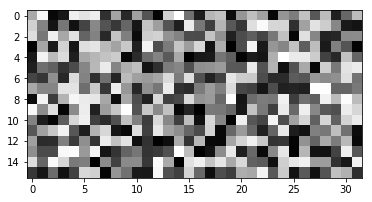

In [10]:
# Visualize weights
W = model.layers[0].get_weights()
W = np.squeeze(W[0])
print("W shape : ", W.shape)
W = np.squeeze(W[0])
print(W.shape)

plt.imshow(W.reshape(16,32), interpolation='none', cmap=plt.cm.gray) 

# pl.figure(figsize=(15, 15))
# pl.title('conv1 weights')
# nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

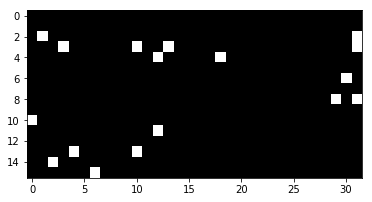

In [11]:
#find pattern
W = model.layers[0].get_weights()
weights = np.squeeze(W[0])

inp = np.zeros((28,28))
inp[1:5:2,::3] = 1
inp = inp.reshape((784,))

outp = inp.dot(weights) > 1

plt.imshow(outp.reshape(16,32), interpolation='none', cmap=plt.cm.gray) 

In [12]:
inp = np.ones((784,))
outp = inp.dot(weights)
average_act = np.sum(outp)/512

W shape :  (512, 28, 28)


/Users/IldefonsoPica/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:860: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/IldefonsoPica/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:861: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


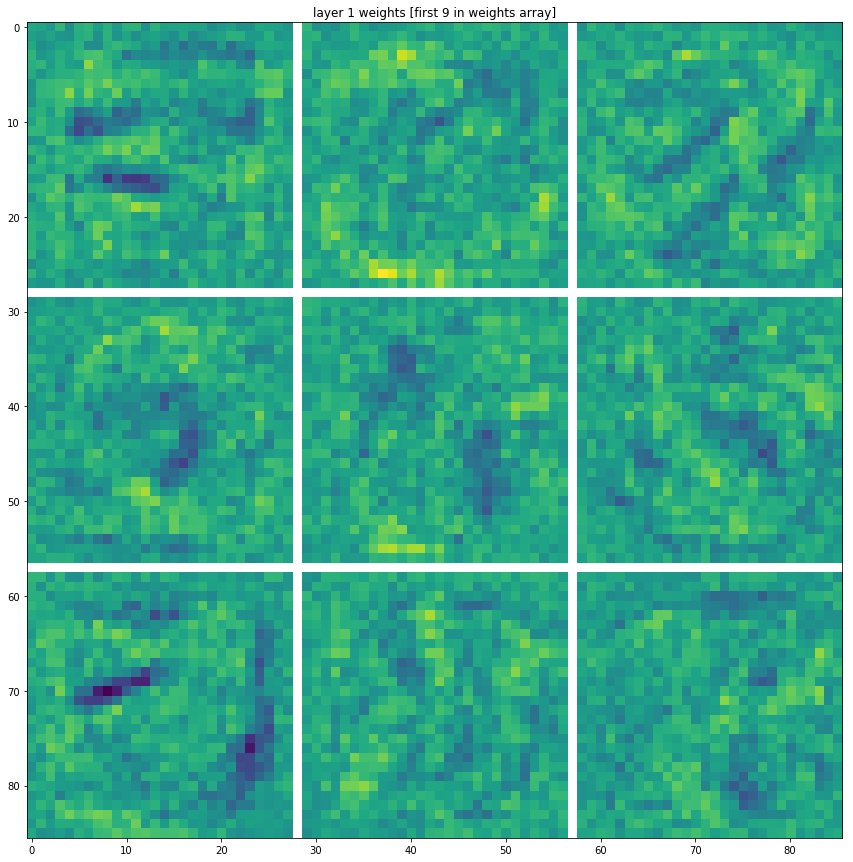

In [13]:
# NEW Visualize weights
# Get the weights of the first layer
W = model.layers[0].get_weights()[0]
# Reshape the weights array to get the 28 x 28 shape of the input data
W = W.T
W = W.reshape(512,28,28)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('layer 1 weights [first 9 in weights array]')
pl.imshow(make_mosaic(W[0:9], 3, 3, border=1))

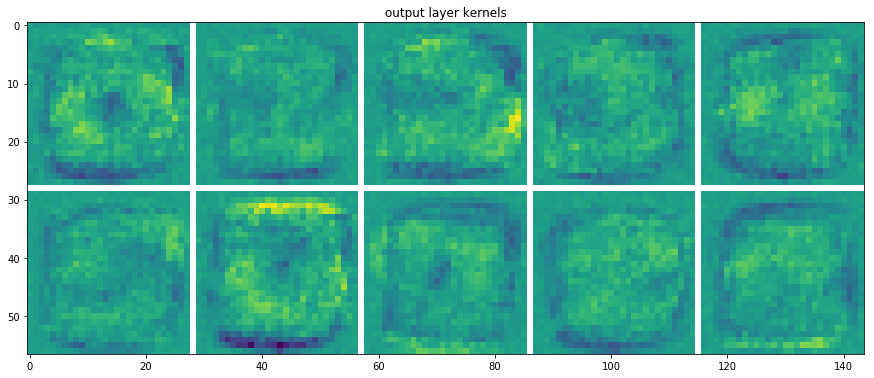

In [14]:
# Get the weights of the final layer
L4Wt = model.layers[4].get_weights()[0]
L4Wt = L4Wt.T
nodes = np.zeros((10,28,28))
idx = 0
for node in L4Wt:
    # Matrix vector product of the weights vector corresponding with node 0
    # and the weights matrix of the preceding layer (layer 2)
    node = np.dot(model.layers[2].get_weights()[0],node)
    # Matrix vector product of the previously computed weights vector
    # and the weights matrix of the input layer (layer 0)
    node = np.dot(model.layers[0].get_weights()[0],node)
    node = node.reshape(28,28)
    nodes[idx,:,:] = node
    idx += 1
pl.figure(figsize=(15, 15))
pl.title('output layer kernels')
pl.imshow(make_mosaic(nodes, 2, 5, border=1))